# Transfer Learning with MobileNetV2


## Packages

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

### Create the Dataset and Split it into Training and Validation Sets

In [7]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 9 files belonging to 1 classes.
Using 8 files for training.
Found 9 files belonging to 1 classes.
Using 1 files for validation.


**Note:** The original dataset has some mislabelled images in it as well.

## Preprocess and Augment Training Data

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:

def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

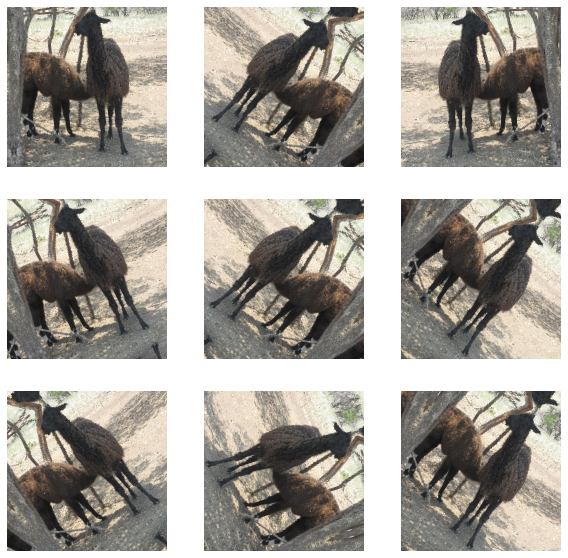

In [12]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Next, we'll apply our first tool from the MobileNet application in TensorFlow, to normalize our input. Since we're using a pre-trained model that was trained on the normalization values [-1,1]

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [14]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14536120/14536120 [==============================] - 24s 2us/step


#### Model Summary

In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

Top layers that resposible for classification in the model

In [16]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


First batch from the tensorflow dataset to use the images, and run it through the MobileNetV2 base model to test out the predictions on some of your images. 

In [18]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(8, 1000)


In [19]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(8,), dtype=int32, numpy=array([0, 0, 0, 0, 0, 0, 0, 0])>

Decoding the predictions made by the model

In [20]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

35363/35363 [==============================] - 0s 6us/step


[[('n02437616', 'llama', 0.2779399), ('n02415577', 'bighorn', 0.063382134)],
 [('n02437616', 'llama', 0.15466724),
  ('n02092002', 'Scottish_deerhound', 0.120135866)],
 [('n02437312', 'Arabian_camel', 0.29232737),
  ('n02437616', 'llama', 0.2771354)],
 [('n02437616', 'llama', 0.41331825), ('n02412080', 'ram', 0.313642)],
 [('n02437616', 'llama', 0.5789033), ('n02114548', 'white_wolf', 0.08629912)],
 [('n02415577', 'bighorn', 0.41784668), ('n02437616', 'llama', 0.28550348)],
 [('n02437616', 'llama', 0.78292173), ('n02415577', 'bighorn', 0.04114262)],
 [('n02437616', 'llama', 0.72264874),
  ('n02437312', 'Arabian_camel', 0.0690173)]]

None of the labels say "alpaca."

This is because MobileNet pretrained over ImageNet doesn't have the correct labels for alpacas

### 3.2 - Layer Freezing with the Functional API


### Alpaca_model

In [21]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    
    input_shape = image_shape + (3,)
    
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, 
                                                   weights='imagenet')
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    x = tf.keras.layers.Dropout(0.2)(x)
        
    # prediction layer (Binary classification)
    outputs = tf.keras.layers.Dense(1)(x)
        
    model = tf.keras.Model(inputs, outputs)
    
    return model

Create your new model using the data_augmentation function defined earlier.

In [22]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

9406464/9406464 [==============================] - 5s 1us/step


In [38]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 10s 1s/step - loss: 0.8357 - accuracy: 0.4809 - val_loss: 0.5392 - val_accuracy: 0.6615
Epoch 2/5
9/9 [==============================] - 9s 968ms/step - loss: 0.6518 - accuracy: 0.6412 - val_loss: 0.4408 - val_accuracy: 0.7538
Epoch 3/5
9/9 [==============================] - 8s 836ms/step - loss: 0.5171 - accuracy: 0.7023 - val_loss: 0.3843 - val_accuracy: 0.8154
Epoch 4/5
9/9 [==============================] - 8s 890ms/step - loss: 0.4650 - accuracy: 0.7557 - val_loss: 0.3343 - val_accuracy: 0.8308
Epoch 5/5
9/9 [==============================] - 8s 834ms/step - loss: 0.3901 - accuracy: 0.7977 - val_loss: 0.3109 - val_accuracy: 0.8462


Plot the training and validation accuracy:

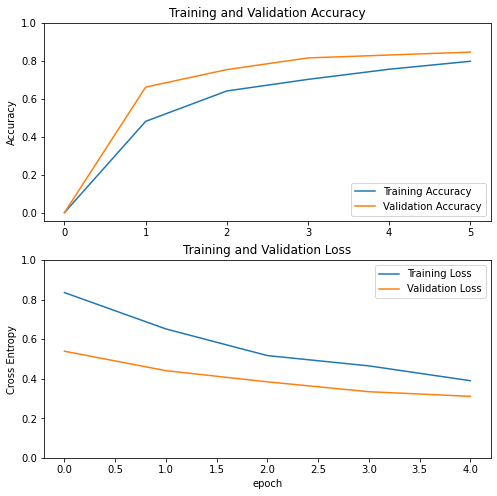

In [41]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [42]:
class_names

['alpaca', 'not alpaca']

The results could be better. -> fine-tuning.

In [55]:
base_model = model2.layers[4]
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
loss_function= tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)
metrics= ['accuracy']


model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  155


In [57]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 10s 1s/step - loss: 0.6506 - accuracy: 0.7252 - val_loss: 0.4162 - val_accuracy: 0.6769
Epoch 6/10
9/9 [==============================] - 9s 1s/step - loss: 0.4168 - accuracy: 0.7557 - val_loss: 0.2010 - val_accuracy: 0.9385
Epoch 7/10
9/9 [==============================] - 9s 1s/step - loss: 0.2955 - accuracy: 0.8626 - val_loss: 0.1588 - val_accuracy: 0.9385
Epoch 8/10
9/9 [==============================] - 9s 1s/step - loss: 0.2185 - accuracy: 0.9122 - val_loss: 0.1217 - val_accuracy: 0.9385
Epoch 9/10
9/9 [==============================] - 9s 1s/step - loss: 0.1945 - accuracy: 0.9122 - val_loss: 0.1714 - val_accuracy: 0.9231
Epoch 10/10
9/9 [==============================] - 9s 1s/step - loss: 0.1950 - accuracy: 0.8969 - val_loss: 0.0722 - val_accuracy: 0.9846


In [58]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

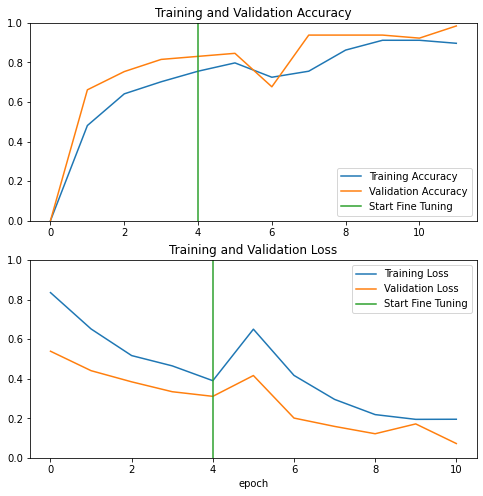

In [59]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Done!

* Created a dataset from a directory
* Augmented data with the Sequential API
* Adapted a pretrained model to new data with the Functional API and MobileNetV2
* Fine-tuned the classifier's final layers and boosted the model's accuracy